In [1]:
import torch.nn as nn
import torch
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [93]:
# SiLU https://arxiv.org/pdf/1905.02244.pdf ----------------------------------------------------------------------------
class SiLU(nn.Module):  # export-friendly version of nn.SiLU()
    @staticmethod
    def forward(x):
        return x * F.sigmoid(x)

In [94]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [95]:
def __init__(self, params):
    super(Net, self).__init__()
    
    C_in,H_in,W_in=params["input_shape"] 
    self.dropout_rate=params["drop_rate"] 
    self.num_fc1 = params["num_fc1"]

    misnet_s = timm.create_model('mixnet_s', pretrained=False)
    
    in_features = misnet_s.classifier.in_features
    
    misnet_s.classifier = nn.Linear(in_features, self.num_fc1)
    
    self.backbone = nn.Sequential(
                    misnet_s,
                    nn.BatchNorm1d(num_features=self.num_fc1),
                    nn.ReLU()
    )
    
    self.gender_head = nn.Sequential(
                            nn.Dropout(p=self.dropout_rate),
                            nn.Linear(self.num_fc1, 1),
                            nn.Sigmoid()
    )
    
    self.age_head = nn.Sequential(
                    nn.Linear(self.num_fc1, 1)
    )
    

In [96]:
def forward(self, x):
    x = self.backbone(x)  
    
    gender = self.gender_head(x)
    age = self.age_head(x)
    
    return age, gender

In [105]:
Net.__init__= __init__
Net.forward = forward

params_model={
        "input_shape": (3,224,224),
        "drop_rate" : 0.2,
        "num_fc1" : 512,
    }

model = Net(params_model)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

Let's use 4 GPUs!


In [106]:
checkpoint = torch.load('../models/exp_2020_12_11-09_27_13/best_checkpoints.bin')
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

<All keys matched successfully>

In [107]:
if isinstance(model, torch.nn.DataParallel):
        model = model.module

In [108]:
model.eval()

Net(
  (backbone): Sequential(
    (0): EfficientNet(
      (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): ReLU(inplace=True)
            (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act2): Identity()
          )
        )
        (1): Sequential(
          (0): InvertedResidual(
            (conv_pw): MixedConv2d(
              (0): Conv2d(8, 48, kernel_size=(1, 1)

In [109]:
def replace_nnSiLU_to_SiLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.SiLU):
            setattr(model, child_name, SiLU())
        else:
            replace_nnSiLU_to_SiLU(child)
            
replace_nnSiLU_to_SiLU(model)

In [110]:
import torch.onnx

In [111]:
# Input to the model

batch_size = 1    # just a random number

x = torch.randn(batch_size, 3, 224, 224, requires_grad=True)
torch_out = model(x)

ONNX_PATH = '../models/age_gender_misnet.onnx'

# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  f = ONNX_PATH,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  verbose = False,
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output_age', 'output_gender'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output_age' : {0 : 'batch_size'},
                                'output_gender' : {0 : 'batch_size'}}
                 )

In [112]:
import onnx

onnx_model = onnx.load("../models/age_gender_misnet.onnx")
onnx.checker.check_model(onnx_model)

In [113]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("../models/age_gender_misnet.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
for i, result in enumerate(torch_out):
    np.testing.assert_allclose(to_numpy(result), ort_outs[i], rtol=1e-03, atol=1e-05)
    print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!
Exported model has been tested with ONNXRuntime, and the result looks good!


In [125]:
meanR,meanG,meanB = 0.54568475 ,0.42776844 ,0.3761094
stdR,stdG,stdB = 0.21924357, 0.18996198, 0.17315607

def get_val_transforms():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(meanR,meanG,meanB), std=(stdR,stdG,stdB)),
        ToTensorV2(),
    ])

df = pd.read_csv("/home/Data/all/testing.csv")
img = cv2.imread(df['file_name'][500], cv2.IMREAD_COLOR)

out = img.copy()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32')

img /= 255.0

img = get_val_transforms()(image = img)['image']

age, gender = df['age'][0], df['gender'][0]

img = torch.unsqueeze(img, 0)

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_age = ort_outs[0]
img_out_gd = ort_outs[1]

Text(0.5, 1.0, 'Age :21-[[25.087376]], Gender: 0-[[0.3627907]]')

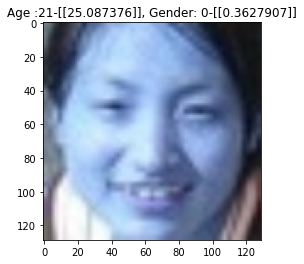

In [126]:
plt.imshow(out)
plt.title(f'Age :{age}-{img_out_age}, Gender: {gender}-{img_out_gd}')

In [116]:
from onnx_tf.backend import prepare
import onnx

TF_PATH = '../models/age_gender_mixnet'
ONNX_PATH = '../models/age_gender_misnet.onnx'

onnx_model = onnx.load(ONNX_PATH)

tf_rep = prepare(onnx_model)

tf_rep.export_graph(TF_PATH)

INFO:tensorflow:Assets written to: ../models/age_gender_mixnet/assets


INFO:tensorflow:Assets written to: ../models/age_gender_mixnet/assets


In [127]:
import tensorflow as tf

TF_PATH = '../models/age_gender_mixnet'
TFLITE_PATH_V1 = '../models/age_gender_mixnet_v1.tflite'


converter = tf.lite.TFLiteConverter.from_saved_model(
    TF_PATH
#     input_arrays = ['input'],
#     output_arrays = ['output']
)

# converter = tf.compat.v1.lite.TFLiteConverter.from_sav(
#     graph_def_file='../models/age_gender_mixnet',
#     input_arrays=['input'],
#     output_arrays=['output'],
# )

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open(TFLITE_PATH_V1, 'wb') as f:
    f.write(tflite_quant_model)

ValueError: This function takes in a list of ConcreteFunction.

In [ ]:
TFLITE_PATH_V2 = '../models/age_gender_mixnet_v2.tflite'
TFLITE_PATH_V3 = '../models/age_gender_mixnet_v3.tflite'